In [1]:
# TRIANGULAR LATTICE APPROACH 1

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM, GRU
# from tensorflow.keras.layers import Activation
# import tensorflow as tf
# from tensorflow.keras.layers import SimpleRNN, Dense
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
from itertools import islice

In [35]:
# 50 by 50 grid
N = 6

In [36]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

lattice_hot = np.random.random_integers(0,1,(N,N))
lattice_hot[lattice_hot==0] =- 1

lattice_cold = np.ones((N,N))

/tmp/ipykernel_13486/822622574.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  lattice_hot = np.random.random_integers(0,1,(N,N))


Show initial lattice of spins

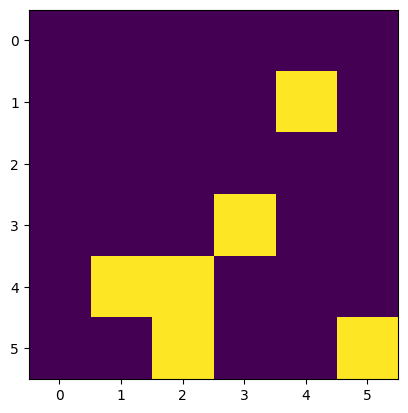

In [37]:
plt.imshow(lattice_n)

Function to get the energy $E/J = -\sum_{<i,j>} \sigma_i\sigma_j$

In [6]:
def bc(i):
    if i > N-1:
        return 0
    if i < 0:
        return N-1
    else:
        return i

In [7]:
def energy_nm(lattice, n, m):
    return 1 * lattice[n,m] * (lattice[bc(n-1), m] + lattice[bc(n+1), m] + lattice[n, bc(m-1)] + lattice[n, bc(m+1)] + lattice[bc(n+1), bc(m-1)] + lattice[bc(n-1), bc(m+1)])

def Energy(lattice):
    energy=0
    for j in range(0,N):
        for k in range(0,N):
            energy+=energy_nm(lattice,j,k)
    return energy/2

In [8]:
Energy(lattice_p)

12.0

In [31]:
Energy(np.array([[-1.,  1., -1., -1., -1., -1.],
        [-1.,  1.,  1.,  1.,  1.,  1.],
        [-1., -1., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1., -1.],
        [-1., -1., -1., -1.,  1.,  1.],
        [ 1.,  1.,  1.,  1., -1., -1.]]))

-24.0

**The metropolis algorithm**:

* Takes in initial 2d grid of spins, number of time steps to run algoritm for, and temperature $BJ$
* Returns the total spin of all the atoms

In [10]:
# @numba.njit("Tuple((f8[:], f8[:], boolean[:, :, :]))(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
@numba.jit(nopython=True)
def metropolis(lattice, times, BJ, energy):
    lattice = lattice.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    lattices = np.zeros((times-1,N,N), dtype=np.bool_)

    def bc(i):
        if i > N-1:
            return 0
        if i < 0:
            return N-1
        else:
            return i
        
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        # x = np.random.randint(0,N)
        # y = np.random.randint(0,N)
        # spin_i = lattice[x,y] #initial spin
        # spin_f = spin_i*-1 #proposed spin flip
        
        # # compute change in energy
        # E_i = 0
        # E_f = 0
        # if x>0:
        #     E_i += -spin_i*lattice[x-1,y]
        #     E_f += -spin_f*lattice[x-1,y]
        # if x<N-1:
        #     E_i += -spin_i*lattice[x+1,y]
        #     E_f += -spin_f*lattice[x+1,y]
        # if y>0:
        #     E_i += -spin_i*lattice[x,y-1]
        #     E_f += -spin_f*lattice[x,y-1]
        # if y<N-1:
        #     E_i += -spin_i*lattice[x,y+1]
        #     E_f += -spin_f*lattice[x,y+1]
        
        # # 3 / 4. change state with designated probabilities
        # dE = E_f-E_i

        # if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
        #     lattice[x,y]=spin_f
        #     energy += dE
        # elif dE<=0:
        #     lattice[x,y]=spin_f
        #     energy += dE

        # Lattice_flip=lattice.copy()
        # dE=0
        # for i in range(5):
        j = np.random.randint(0,N)
        k = np.random.randint(0,N)
        
        sum_nn = lattice[bc(j-1), k] + lattice[bc(j+1), k] + lattice[j, bc(k-1)] + lattice[j, bc(k+1)] + lattice[bc(j+1), bc(k-1)] + lattice[bc(j-1), bc(k+1)]
        # Lattice_flip[j,k] = -lattice[j,k]
        new_spin=-lattice[j,k]
        # dE =-1*(Lattice_flip[j,k]-lattice[j,k])*sum_nn
        dE =1*(new_spin-lattice[j,k])*sum_nn
        # lattice=Lattice_flip
        
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            lattice[j,k]=new_spin
            energy += dE
        elif dE<=0:
            lattice[j,k]=new_spin
            energy += dE
            
        net_spins[t] = lattice.sum()
        net_energy[t] = energy
        lattices[t,:,:]=(lattice+1).astype(np.bool_)
            
    return net_spins, net_energy, lattices

Get arrays of spins and energies throughout the dance (this is NOT representative of time evolution: its merely a tool used to reach equilibrium)

In [17]:
betaa=100

In [18]:
spins, energies, lattices = metropolis(lattice_n, 10000, betaa, Energy(lattice_n))

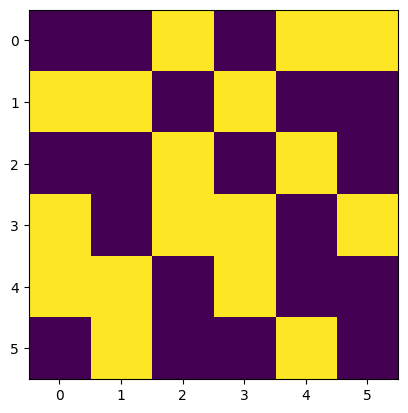

In [19]:
plt.imshow(lattices[-30,:,:])

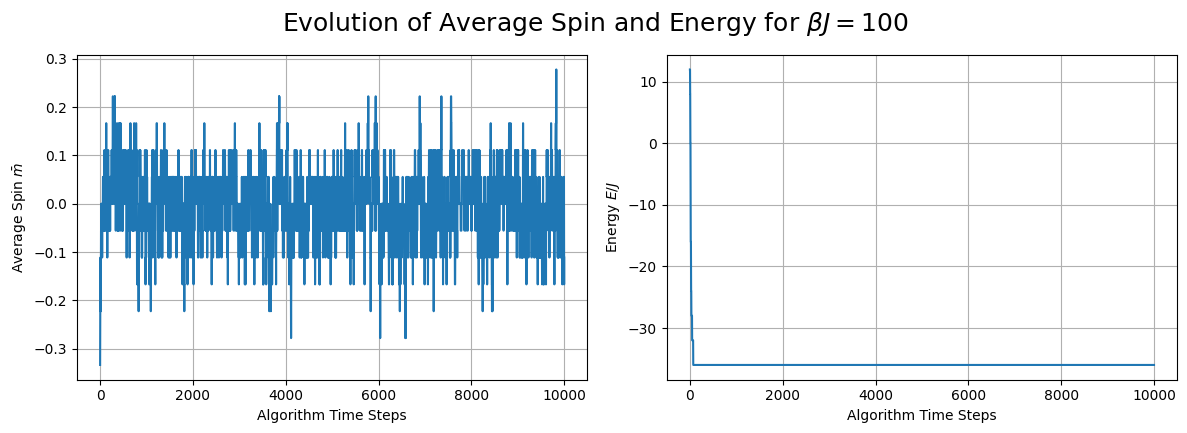

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$'+str(betaa), y=1.07, size=18)
plt.show()

We can get $\bar{m}$ and $E/J$ for many different values of $\beta J$. The values will be the average of the last 100000 points on the figure above.

In [22]:
def get_spin_energy(lattice, BJs, Data_len, Max_iteration):
    ms = np.zeros((len(BJs),Data_len))
    E = np.zeros((len(BJs),Data_len))
    Lattices = np.zeros((len(BJs),Data_len,N,N), dtype=np.bool_)
    for i, bj in enumerate(BJs):
        spins, energies, lattices = metropolis(lattice, Max_iteration, bj, Energy(lattice))
        ms[i,:] = spins[-Data_len:]
        E[i,:] = energies[-Data_len:]
        Lattices[i,:,:,:] = lattices[-Data_len:,:,:]
        print(i)
    return ms, E, Lattices

Max_iteration=100001
Data_len=10000
# BJs = np.arange(0.1, 2, 0.1)
T= np.arange(0.01,10,0.6)
BJs=1/T
ms_n, E_n, Lattices_n = get_spin_energy(lattice_n, BJs, Data_len, Max_iteration)
ms_p, E_p, Lattices_p = get_spin_energy(lattice_p, BJs, Data_len, Max_iteration)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


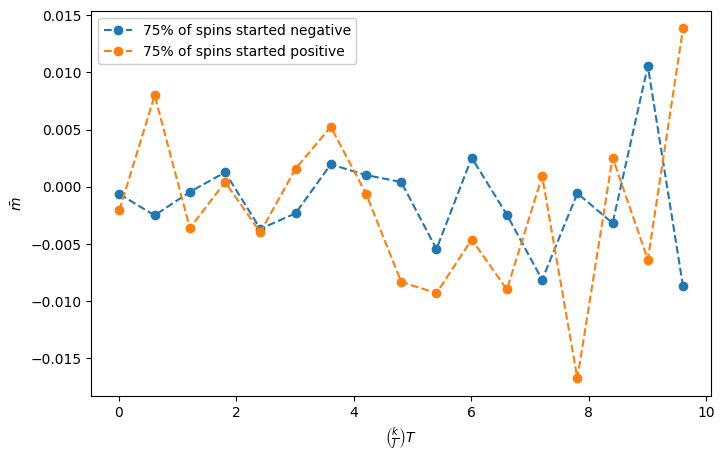

In [23]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n.mean(axis=1)/N**2, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p.mean(axis=1)/N**2, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [24]:
BJS_n=np.repeat(BJs,Data_len)
BJS_p=np.repeat(BJs,Data_len)
BJS=np.concatenate((BJS_n,BJS_p),axis=0)

Energies=np.concatenate((E_n.flatten(),E_p.flatten()),axis=0)

Lattices=np.concatenate((Lattices_n.reshape((Data_len*len(BJs),N,N)),Lattices_p.reshape((Data_len*len(BJs),N,N))),axis=0)

Lattices = torch.tensor([((lattice.astype(np.int8) - 1/2) * 2).astype(np.float32) for lattice in Lattices])

Energies = torch.tensor(Energies, dtype=torch.float32)
BJS = torch.tensor(BJS, dtype=torch.float32)

dataset = TensorDataset(Lattices, Energies, BJS)

Batch_size=64
dataloader = DataLoader(dataset, batch_size=Batch_size, shuffle=True)

/tmp/ipykernel_13486/3904738065.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025569485/work/torch/csrc/utils/tensor_new.cpp:275.)
  Lattices = torch.tensor([((lattice.astype(np.int8) - 1/2) * 2).astype(np.float32) for lattice in Lattices])


In [38]:
# testing that sum of all lattice configs is equal to 1

class ProductRNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN1, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output 2 numbers: one for each +1, -1

    def forward(self, bj, x):
        x = x.view(x.size(0), -1,1) # flatten + transpose
        # print(((x+1)/2).shape)
        # print(x[:,0:-1,:].shape)
        Zeros=torch.zeros(x.size(0), 1, 1)
        #bj.view(-1,1,1)
        x_0=torch.cat((bj.view(-1,1,1),x[:,0:-1,:]), dim=1)
        # print(x_0.shape)
        # x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.view(-1,1,1).shape)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # print(x)
        out, _ = self.rnn(x_0, h0)
        # print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # print(out.shape)
        out = F.log_softmax(out, dim=2) # normalizing o/p at each time stamp
        extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values.shape)
        sum_result = extracted_values.sum(dim=1)
        # print(sum_result.shape)
        # print(out)
        
        
        # out = F.softmax(out, dim=2) # normalizing o/p at each time stamp
        # print(out)
        # extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values)
        # sum_result = torch.prod(extracted_values,dim=1)
        # print(sum_result.shape)
        return sum_result

    def generate_lattice(self, bj, n_iterations):
        # bj is tensor(0.300) for example
        # Ensure bj is a tensor and has the correct shape
        x=bj.view(-1,1,1)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(bj.device)
        # Initialize the generated lattice configuration
        generated_lattice = np.zeros((x.size(0),n_iterations))

        with torch.no_grad():
            for i in range(n_iterations):
                # print(x.shape)
                out, h0 = self.rnn(x, h0)
                # print(out)
                # print(h0)
                out = self.fc(out)
                out = F.softmax(out, dim=2)
                # print(out.shape)
                # print(out)
                # Sample from the output probabilities
                # print(out[:, -1, :])
                
                array=out[:,-1,:]
                # print(array)
                # array[3]=torch.tensor([0.1,0.9])
                condi=(array[:, 0] > array[:, 1]).float().view(-1,1)
                # print(array,torch.concatenate((condi,1-condi),dim=1))
                # max_values, _ = array.max(dim=1, keepdim=True)
                # print(max_values)
                modified_array = (torch.concatenate((condi,1-condi),dim=1)*9+1)*array
                # modified_array = torch.where(array[:, 0] > array[:, 1], torch.tensor([1, 10]), torch.tensor([10, 1]))
                # print(modified_array)
                sampled_index = torch.multinomial(modified_array, 1)
                
                # sampled_index = torch.multinomial(out[:, -1, :], 1)
                
                # print(sampled_index.shape)
                # print(sampled_index)
                # Map sampled index to -1 or +1
                x = (2 * sampled_index - 1).float()
    
                # Append the sampled value to the generated lattice
                generated_lattice[:,i]=x.view(-1)
                x=x.view(-1,1,1)
    
        return generated_lattice.reshape(-1, int(np.sqrt(n_iterations)), int(np.sqrt(n_iterations)))


In [39]:
# testing that sum of all lattice configs is equal to 1

class ProductRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN2, self).__init__()
        self.rnn = nn.RNN(input_size+1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output 2 numbers: one for each +1, -1

    def forward(self, bj, x):
        x = x.view(x.size(0), -1,1) # flatten + transpose
        # print(((x+1)/2).shape)
        # print(x[:,0:-1,:].shape)
        Zeros=torch.zeros(x.size(0), 1, 1)
        #bj.view(-1,1,1)
        # print(x[:,0:-1,:].shape,Zeros.shape)
        x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.repeat(x_0.size(1)).view(-1,x_0.size(1),1).shape)
        x_0=torch.cat((x_0,bj.repeat(x_0.size(1)).view(-1,x_0.size(1),1)),dim=2)
        # print(x_0)
        # print(x_0)
        # x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.view(-1,1,1).shape)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # print(x_0[:,:,0].view(16,9,1).shape)
        # print(x_0[:,:,0].view(-1,4,1))
        out, _ = self.rnn(x_0, h0)
        # print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # print(out.shape)
        out = F.log_softmax(out, dim=2) # normalizing o/p at each time stamp
        extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values.shape)
        sum_result = extracted_values.sum(dim=1)
        # print(sum_result.shape)
        # print(out)
        
        
        # out = F.softmax(out, dim=2) # normalizing o/p at each time stamp
        # print(out)
        # extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values)
        # sum_result = torch.prod(extracted_values,dim=1)
        # print(sum_result.shape)
        return sum_result

    def generate_lattice(self, bj, n_iterations):
        # bj is tensor(0.300) for example
        # Ensure bj is a tensor and has the correct shape
        x=bj.view(-1,1,1)
        Zeros=torch.zeros(x.size(0), 1, 1)
        # print(Zeros.shape,x.shape)
        x=torch.cat((Zeros,x), dim=2)
        # print(x)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(bj.device)
        # Initialize the generated lattice configuration
        generated_lattice = np.zeros((x.size(0),n_iterations))

        with torch.no_grad():
            for i in range(n_iterations):
                # print(x.shape)
                out, h0 = self.rnn(x, h0)
                # print(out)
                # print(h0)
                out = self.fc(out)
                out = F.softmax(out, dim=2)
                # print(out.shape)
                # print(out[:, -1, :].shape)
                # Sample from the output probabilities
                # print(out[:, -1, :])
                sampled_index = torch.multinomial(out[:, -1, :], 1)
                # print(sampled_index.shape)
                # print(sampled_index)
                # Map sampled index to -1 or +1
                x = (2 * sampled_index - 1).float()
    
                # Append the sampled value to the generated lattice
                generated_lattice[:,i]=x.view(-1)
                x=x.view(-1,1,1)
                x=torch.cat((x,bj.view(-1,1,1)), dim=2)
                # print(x)
    
        return generated_lattice.reshape(-1, int(np.sqrt(n_iterations)), int(np.sqrt(n_iterations)))


In [121]:
input_size=1
hidden_size=10
num_layers=1
Log_q = ProductRNN1(input_size, hidden_size, num_layers)

optimizer = optim.Adam(Log_q.parameters(), lr=0.001)


In [122]:
batch_loss=[[] for i in range(len(BJs))]

In [123]:
Loss=[]

In [124]:
num_epochs = 14

In [125]:
# lattice_ = (Lattices[0,:,:].astype(np.int8)-1/2)*2
# lattice = torch.tensor(lattice_, dtype=torch.float32)
# Log_q(lattice)[0]
# 1

In [126]:
def free_energy(lattice, energy, bj, log_q):
    log__q = log_q(bj,lattice).view(-1)
    # print(log__q)
    # print(energy*bj + log__q)
    # log_q = torch.log(output)
    # print(log__q.shape)
    # print(energy.shape)
    # print((energy*bj).shape)
    
    # log_loss = -(log__q + torch.log(-energy*bj - log__q))

    condition = (energy * bj + log__q) < 0
    # print(bj)
    # print(energy * bj)
    for i in condition:
        if i==False:
            print('---')
    positive_loss = -(log__q + torch.log(-(energy * bj + log__q)))
    negative_loss = log__q + torch.log(energy * bj + log__q)
    log_loss = torch.where(condition, positive_loss, negative_loss)
    
    # log_loss = (energy*bj + log__q)**2
    
    # print('b')
    # print(log_loss,torch.sum(log_loss))
    # print(log_loss.shape)
    return log_loss

# torch.autograd.set_detect_anomaly(False)

# Batch_size = 64

for epoch in range(num_epochs):
    total_loss = 0

    # for i in range(int(len(Lattices)/1000)):
        # #lattice_ = (Lattices[i].astype(np.int8)-1/2)*2
    #     lattice = torch.tensor(lattice_, dtype=torch.float32)
    #     energy = Energies[i]
    #     bj = BJS[i]

    #     optimizer.zero_grad()
    #     # print('a')
    #     # Calculate the objective function and backpropagate
    #     loss = free_energy(lattice, energy, bj, Log_q)
    #     # print('b')
    #     # print(loss)
    #     total_loss += loss#.item()
    #     if (i%200==0):
    #         print(i)
    #     # l

    # num_batches_to_use = 100

    for batch_idx, (lattices_batch, energies_batch, bjs_batch) in enumerate(dataloader):
    # for batch_idx, (lattices_batch, energies_batch, bjs_batch) in itertools.islice(enumerate(dataloader), num_batches_to_use):
        optimizer.zero_grad()
        # Calculate the objective function and backpropagate
        loss = free_energy(lattices_batch, energies_batch, bjs_batch, Log_q)
        total_loss += loss.mean()/N**2
        # print(total_loss)
        # print(energies_batch)
        # l
        
        if (batch_idx % 200 == 0):
            print(batch_idx)
    
        ((loss.mean())/N**2).backward()
        optimizer.step()

        # for jj in range(len(BJs)):
        #     I=torch.nonzero(bjs_batch==BJs[jj]).view(-1)
        #     # print(I)
        #     # print(loss[I].mean())
        #     batch_loss[jj].append(((loss[I].mean())/N**2).item())
        #     # for kk in range(len(bjs_batch)):
        #     #     if bjs_batch[kk]==BJs[jj]:
        #     #         batch_loss[jj].append(((loss)/N**2)[kk].item())
        # mknn
    # total_loss.backward()
    # optimizer.step()
    Loss.append(total_loss.item())
    # Print the total loss for this epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss}')
plt.plot(Loss)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
Epoch 1/14, Total Loss: 2897.11376953125
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
Epoch 2/14, Total Loss: 2873.58203125
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
Epoch 3/14, Total Loss: 2869.508056640625
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
Epoch 4/14, Total Loss: 2867.44677734375
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
Epoch 5/14, Total Loss: 2865.62109375
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
Epoch 6/14, Total Loss: 2863.541

KeyboardInterrupt: 

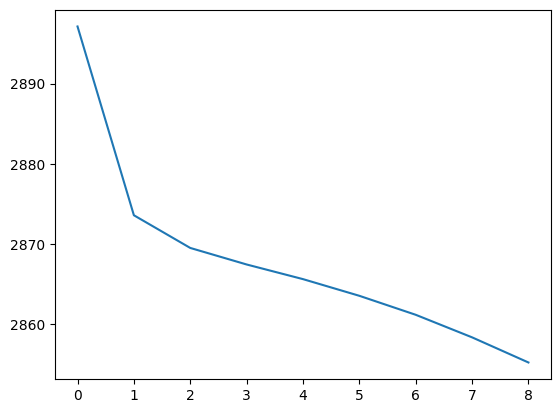

In [127]:
plt.plot(Loss)

In [99]:
# for i in range(len(BJs)):
#     plt.plot(np.array(batch_loss[i]))

Text(0, 0.5, '$S$')

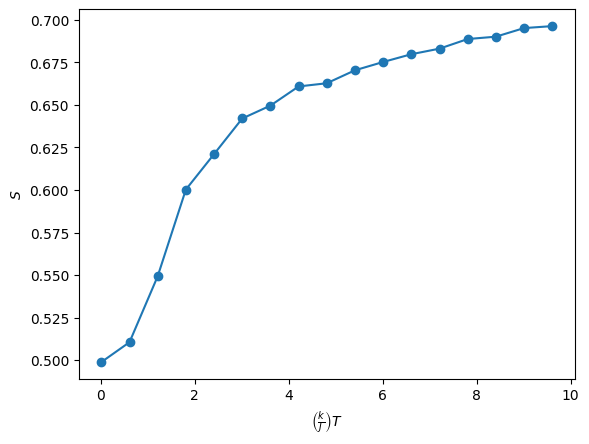

In [128]:
S=np.zeros(len(BJs))
for i in range(len(BJs)):
    with torch.no_grad():
        I=torch.nonzero(BJS==BJs[i]).view(-1)
        bjs_batch=BJS[I]
        lattices_batch=Lattices[I]
        # print(I)
        log__q = Log_q(bjs_batch,lattices_batch).view(-1)
        S[i]=-torch.mean(log__q).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.scatter(1/BJs,S)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

Text(0, 0.5, '$S$')

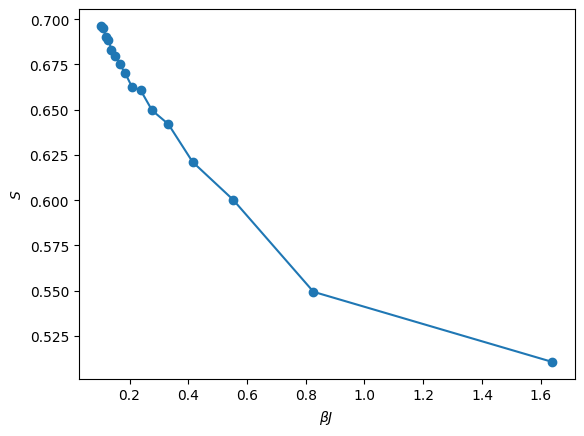

In [129]:
plt.plot(BJs[1:],S[1:])
plt.scatter(BJs[1:],S[1:])
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [130]:
S

array([0.49887678, 0.51057715, 0.54932658, 0.60027138, 0.62109433,
       0.64201683, 0.64958837, 0.66084406, 0.66272895, 0.67034668,
       0.67521784, 0.67978213, 0.68305736, 0.68870354, 0.69008727,
       0.69513877, 0.69629097])

In [334]:
S

array([0.01975021, 0.00231003, 0.03972065, 0.12748795, 0.36386622,
       0.55254894, 0.61685467, 0.65138796, 0.65997648, 0.66961988,
       0.67652697, 0.68105925, 0.68045611, 0.68540366, 0.68903907,
       0.68981658, 0.69397089])

In [129]:
1/T

array([100.        ,   1.63934426,   0.82644628,   0.55248619,
         0.41493776,   0.33222591,   0.27700831,   0.23752969,
         0.20790021,   0.18484288,   0.16638935,   0.15128593,
         0.13869626,   0.12804097,   0.11890606,   0.11098779,
         0.10405827])

In [32]:
# # Generate all lattice configs for a single BJ

# M = 2

# # Generate all possible configurations using binary representation
# possible_configs = np.array([list(map(int, list(format(i, '0' + str(M**2) + 'b')))) for i in range(2**(M**2))])

# # Convert 0s to -1s in the array
# possible_configs[possible_configs == 0] = -1

# # print(possible_configs)
# # Reshape the array to MxM
# Lattices = torch.tensor(possible_configs.reshape(-1, M, M))
# # Shape: (2**(M**2), M, M)

# BJS=torch.ones((2**(M**2)))*0.3
# # Lattices
# # Print the result
# # for config in possible_configs:
# #     print(config)

In [33]:


# input_size=1
# hidden_size=3
# num_layers=1
# Log_q = ProductRNN1(input_size, hidden_size, num_layers)

# q=torch.exp(Log_q(BJS,Lattices))
# # print(q.shape)
# print(q.sum())

# # q=Log_q(BJS,Lattices).sum()
# # print(q)

# # Log_q.generate_lattice(BJS[0:12],M**2)
# Log_q.generate_lattice(torch.zeros((12)),M**2)

In [34]:
# input_size=1
# hidden_size=5
# num_layers=1
# Log_q = ProductRNN2(input_size, hidden_size, num_layers)

# # q=torch.exp(Log_q(BJS,Lattices))
# # # print(q.shape)
# # print(q.sum())

# # q=Log_q(BJS,Lattices).sum()
# # print(q)

# Log_q.generate_lattice(BJS[0:12],M**2)

In [58]:
input_size=1
hidden_size=50
num_layers=2

models = []
for _ in range(len(BJs)):
    model = ProductRNN1(input_size, hidden_size, num_layers)
    models.append(model)

optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

In [59]:
Loss=[[] for i in range(len(BJs))]

In [64]:
# train
num_epochs = 3
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:')
    for i in range(len(BJs)):#[len(BJs)-1]:#range(1):#len(BJs)):
        I=torch.nonzero(BJS==BJs[i]).view(-1)
        total_loss = 0
        for j in range(0, len(I)-Batch_size, Batch_size):
            optimizers[i].zero_grad()
            I_batch=I[j:min(j+Batch_size,len(I))]
            BJs_batch=BJS[I_batch]
            Lattice_batch=Lattices[I_batch]
            Energy_batch=Energies[I_batch]

            # print(torch.zeros((Batch_size)).shape,Lattice_batch.shape)
            Log_q_batch=models[i](torch.zeros((Lattice_batch.size(0))),Lattice_batch).view(-1)
            # print(Log_q_batch.shape, Energy_batch.shape, BJs_batch.shape, BJs_batch.view(-1,1).shape)
            # print(Energy_batch)
            loss_batch=(Energy_batch*BJs_batch + Log_q_batch)**2
            # loss_batch=(Energy_batch*BJs_batch + Log_q_batch)
            # print(Log_q_batch)
            # print(Energy_batch)
            # loss_batch=-(Log_q_batch + torch.log(-Energy_batch*BJs_batch - Log_q_batch))

            
            # condition=(Energy_batch*BJs_batch + Log_q_batch)<0
            # # print(Energy_batch.shape,BJs_batch.shape,Log_q_batch.shape)
            # for o in condition:
            #     if o==False:
            #         print('---')
            # positive_loss=-(Log_q_batch + torch.log(-(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
            # negative_loss=(Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
            # loss_batch = torch.where(condition, positive_loss, negative_loss)
            
            # print(loss_batch.shape)
            total_loss_batch=loss_batch.mean()/N**2
            total_loss_batch.backward()
            optimizers[i].step()
            total_loss += loss_batch.mean()/N**2
        Loss[i].append(total_loss.item())
        # print(Energy_batch)
        # kmds
        print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss}')

Epoch 1/3:
Epoch 1/3, Total Loss: 122815264.0
Epoch 1/3, Total Loss: 2018434.0
Epoch 1/3, Total Loss: 1983003.875
Epoch 1/3, Total Loss: 1861555.875
Epoch 1/3, Total Loss: 2166504.5
Epoch 1/3, Total Loss: 2076842.75
Epoch 1/3, Total Loss: 2030881.25
Epoch 1/3, Total Loss: 1957568.375
Epoch 1/3, Total Loss: 1963681.625
Epoch 1/3, Total Loss: 2074611.625
Epoch 1/3, Total Loss: 1837514.0
Epoch 1/3, Total Loss: 1861965.125
Epoch 1/3, Total Loss: 1911300.0
Epoch 1/3, Total Loss: 1761973.0
Epoch 1/3, Total Loss: 1843261.375
Epoch 1/3, Total Loss: 1826072.0
Epoch 1/3, Total Loss: 1870572.25
Epoch 2/3:
Epoch 2/3, Total Loss: 113496128.0
Epoch 2/3, Total Loss: 55215.3984375
Epoch 2/3, Total Loss: 20403.07421875
Epoch 2/3, Total Loss: 15568.5380859375
Epoch 2/3, Total Loss: 17547.181640625
Epoch 2/3, Total Loss: 9060.189453125
Epoch 2/3, Total Loss: 7768.15087890625
Epoch 2/3, Total Loss: 15938.775390625
Epoch 2/3, Total Loss: 6885.47021484375
Epoch 2/3, Total Loss: 6758.5751953125
Epoch 2/3, To

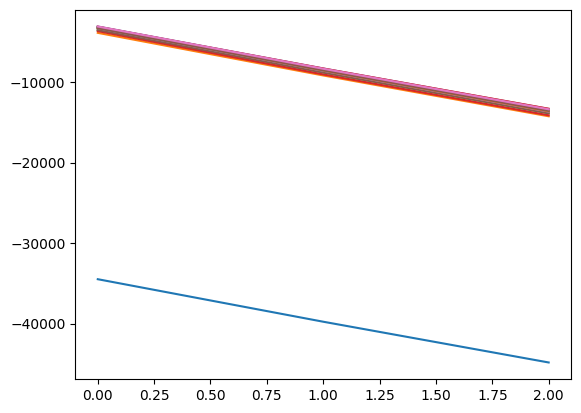

In [62]:
for i in range(0,len(BJs)):
    plt.plot(np.array(Loss[i]))

Text(0, 0.5, '$S$')

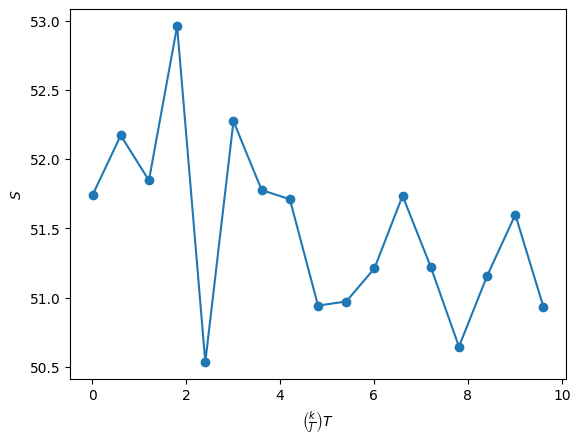

In [63]:
S=np.zeros(len(BJs))
for i in range(len(BJs)):
    with torch.no_grad():
        I=torch.nonzero(BJS==BJs[i]).view(-1)
        bjs_batch=BJS[I]
        lattices_batch=Lattices[I]
        # print(I)
        # print(lattices_batch.size(0),torch.zeros(lattices_batch.size(0)).shape)
        # ds
        Log_q_batch=models[i](torch.zeros(lattices_batch.size(0)),lattices_batch).view(-1)
        S[i]=-torch.mean(Log_q_batch).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.scatter(1/BJs,S)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

Text(0, 0.5, '$S$')

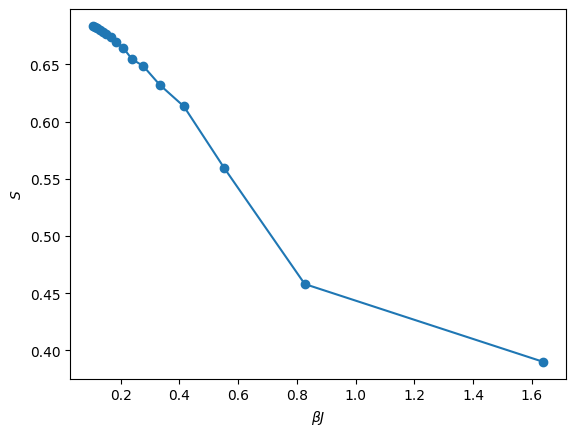

In [55]:
plt.plot(BJs[1:],S[1:])
plt.scatter(BJs[1:],S[1:])
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [56]:
S

array([0.3699935 , 0.38993202, 0.45802413, 0.55938456, 0.61331881,
       0.6323167 , 0.64848783, 0.65482187, 0.66469653, 0.66936641,
       0.67393324, 0.67628675, 0.67869578, 0.68027666, 0.68157445,
       0.68290488, 0.6836737 ])

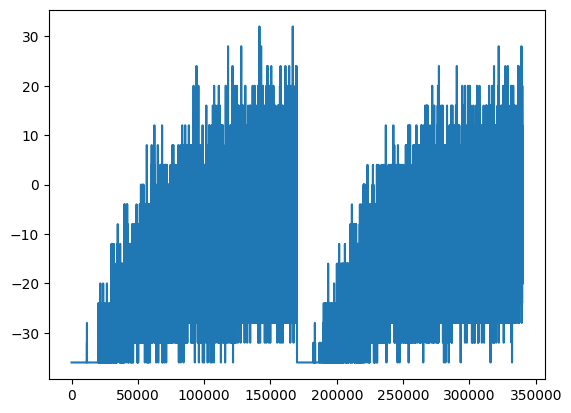

In [70]:
plt.plot(Energies)

In [338]:
T

array([0.01, 0.61, 1.21, 1.81, 2.41, 3.01, 3.61, 4.21, 4.81, 5.41, 6.01,
       6.61, 7.21, 7.81, 8.41, 9.01, 9.61])

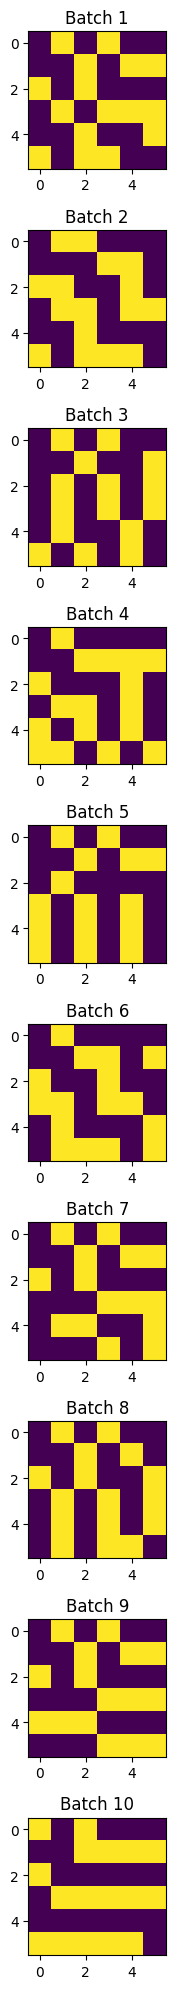

In [57]:
with torch.no_grad():
    I=torch.nonzero(BJS==BJs[0]).view(-1) # CHANGE ME
    I=I[0:10]
    bjs_batch=BJS[I]
    lattices_batch=Lattices[I]
    # print(I)
    # print(bjs_batch)
    Log_q=models[i]
    Lattice_gen = Log_q.generate_lattice(bjs_batch,N**2)
    # plt.imshow(Lattice_gen[0])

    bbatch_size, rows, cols = Lattice_gen.shape
    fig, axs = plt.subplots(nrows=bbatch_size, ncols=1, figsize=(6, 2 * bbatch_size))

    for i in range(bbatch_size):
        axs[i].imshow(Lattice_gen[i])
        # axs[i].imshow(lattices_batch[i])
        axs[i].set_title(f"Batch {i+1}")
        # axs[i].grid(True, which='both', linestyle='--', linewidth=0.5, color='black')

    plt.tight_layout()
    # plt.show()

In [25]:
BJs

array([100.        ,   1.63934426,   0.82644628,   0.55248619,
         0.41493776,   0.33222591,   0.27700831,   0.23752969,
         0.20790021,   0.18484288,   0.16638935,   0.15128593,
         0.13869626,   0.12804097,   0.11890606,   0.11098779,
         0.10405827])

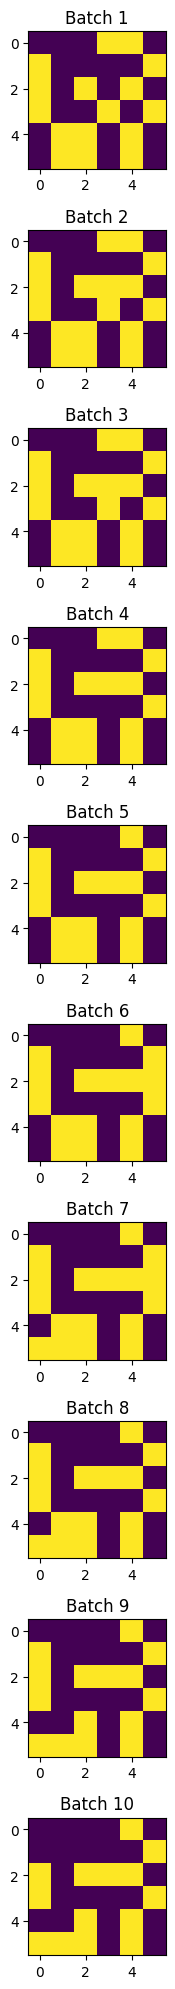

In [33]:
with torch.no_grad():
    I=torch.nonzero(BJS==BJs[-1]).view(-1) # CHANGE ME
    I=I[-10:]
    bjs_batch=BJS[I]
    lattices_batch=Lattices[I]
    # print(I)
    # print(bjs_batch)
    # plt.imshow(Lattice_gen[0])

    # Lattice_gen = Log_q.generate_lattice(bjs_batch,N**2)
    # bbatch_size, rows, cols = Lattice_gen.shape
    bbatch_size, rows, cols = lattices_batch.shape
    fig, axs = plt.subplots(nrows=bbatch_size, ncols=1, figsize=(6, 2 * bbatch_size))

    for i in range(bbatch_size):
        # axs[i].imshow(Lattice_gen[i])
        axs[i].imshow(lattices_batch[i])
        axs[i].set_title(f"Batch {i+1}")
        # axs[i].grid(True, which='both', linestyle='--', linewidth=0.5, color='black')

    plt.tight_layout()
    # plt.show()